c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8022 - val_loss: 0.4933
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4894 - val_loss: 0.4928
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4880 - val_loss: 0.4927
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4865 - val_loss: 0.4927
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4916 - val_loss: 0.4927
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4762 - val_loss: 0.4927
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4912 - val_loss: 0.4927
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4841 - val_loss: 0.4927
Epoch 9/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4888 - val_loss: 0.4927
Epoch 10/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4874 - val_loss: 0.4927
Epoch 11/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4832 - val_loss: 0.4927
Epoch 12/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


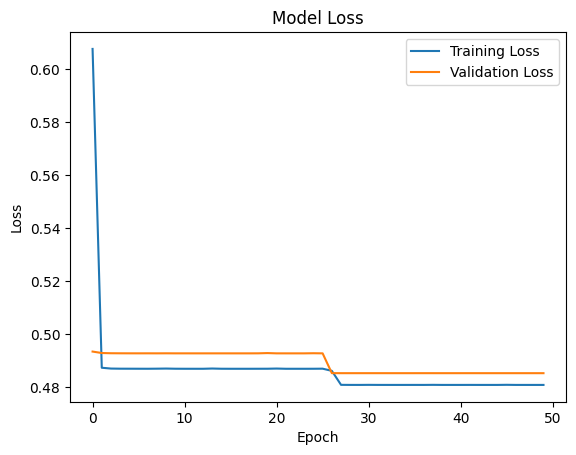

In [1]:
from scapy.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

def process_pcap(pcap_file):
    """Обработка PCAP файла и извлечение признаков"""
    packets = rdpcap(pcap_file)
    features = []
    
    # Словарь для отслеживания статистики по IP адресам
    ip_stats = {}
    
    # Временное окно для агрегации (в секундах)
    window_size = 1
    current_window = packets[0].time
    window_packets = []
    
    for packet in packets:
        if packet.time - current_window > window_size:
            # Извлекаем признаки из накопленных пакетов
            if window_packets:
                features.append(extract_window_features(window_packets))
            # Начинаем новое окно
            window_packets = []
            current_window = packet.time
        
        window_packets.append(packet)
    
    # Обработка последнего окна
    if window_packets:
        features.append(extract_window_features(window_packets))
    
    return pd.DataFrame(features)

def extract_window_features(window_packets):
    """Извлечение признаков из временного окна пакетов"""
    features = {
        'packet_count': len(window_packets),
        'avg_packet_size': 0,
        'arp_count': 0,
        'unique_ips': set(),
        'unique_macs': set(),
        'tcp_count': 0,
        'udp_count': 0,
        'icmp_count': 0
    }
    
    total_size = 0
    
    for packet in window_packets:
        # Размер пакета
        packet_size = len(packet)
        total_size += packet_size
        
        # ARP пакеты
        if ARP in packet:
            features['arp_count'] += 1
            features['unique_macs'].add(packet[ARP].hwsrc)
            features['unique_macs'].add(packet[ARP].hwdst)
        
        # IP пакеты
        if IP in packet:
            features['unique_ips'].add(packet[IP].src)
            features['unique_ips'].add(packet[IP].dst)
            
            # Подсчет протоколов
            if TCP in packet:
                features['tcp_count'] += 1
            elif UDP in packet:
                features['udp_count'] += 1
            elif ICMP in packet:
                features['icmp_count'] += 1
        
        # Ethernet уровень
        if Ether in packet:
            features['unique_macs'].add(packet[Ether].src)
            features['unique_macs'].add(packet[Ether].dst)
    
    # Вычисление средних значений
    features['avg_packet_size'] = total_size / features['packet_count'] if features['packet_count'] > 0 else 0
    features['unique_ips'] = len(features['unique_ips'])
    features['unique_macs'] = len(features['unique_macs'])
    
    return features

def prepare_dataset(pcap_file):
    """Подготовка данных для автокодировщика"""
    # Обработка PCAP файла
    df = process_pcap(pcap_file)
    
    # Нормализация данных
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    return scaled_data, scaler, df.columns

# Основной код
if __name__ == "__main__":
    # Путь к вашему PCAP файлу
    pcap_path = "path_to_your_normal_traffic.pcap"
    
    # Подготовка данных
    scaled_data, scaler, feature_names = prepare_dataset(pcap_path)
    
    # Создание и обучение модели (используем код из предыдущего ответа)
    input_dim = scaled_data.shape[1]
    model = create_autoencoder(input_dim)
    
    # Обучение модели
    history = model.fit(
        scaled_data, scaled_data,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        shuffle=True
    )
    
    # Сохранение модели и параметров
    model.save('autoencoder_model.h5')
    np.save('feature_names.npy', feature_names)
    from joblib import dump
    dump(scaler, 'scaler.joblib')